# US Airport Data

The dataset used is from Kaggle: https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018?select=2018.csv

Data from 2014 - 2018 was combined in one csv file and is used for this project.

Airline name, Airport name, City, State and State abbreviation are from Reporting_Airline, OriginAirportID and OriginState lookup tables in "On-Time : Reporting Carrier On-Time Performance (1987-present)" from "Bureau of Transportation Statistics" website (https://www.bts.gov/) and are included in the project folder


In [1]:
import pandas as pd
import datetime
import numpy as np  
import matplotlib.pyplot as plt  
import ipywidgets as widgets
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Read CSV file
US_flight_data = pd.read_csv("2014_2018.csv")

# Data Cleaning

In [3]:
#Delete unused columns
US_flight_data.drop(['TAXI_OUT', 'WHEELS_OFF','WHEELS_ON', 'TAXI_IN','CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'OP_CARRIER_FL_NUM', 'DEP_TIME',
       'ARR_TIME', 'DIVERTED', 'Unnamed: 27', 'CANCELLED',  'CANCELLATION_CODE'], 
               axis=1, inplace=True)

In [4]:
#Add Carrier (Airline) name
carrier_data = pd.read_csv("L_UNIQUE_CARRIERS.csv_")
US_flight_data = pd.merge(US_flight_data, carrier_data, left_on="OP_CARRIER", 
                                          right_on="Code").drop('Code', axis=1).rename(
                                                            columns={"Description": "Carrier Name"})
US_flight_data

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Carrier Name
0,2014-01-01,AA,ICT,DFW,1135,9.0,1300,2.0,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
1,2014-01-01,AA,MIA,TPA,2225,-5.0,2325,-10.0,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
2,2014-01-01,AA,JFK,LAX,900,14.0,1225,13.0,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
3,2014-01-01,AA,LAX,JFK,930,122.0,1800,111.0,111.0,0.0,0.0,0.0,0.0,American Airlines Inc.
4,2014-01-01,AA,JFK,LAX,1200,-3.0,1510,13.0,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30144610,2018-12-31,YX,JFK,CLE,944,51.0,1146,37.0,37.0,0.0,0.0,0.0,0.0,Republic Airline
30144611,2018-12-31,YX,DCA,LGA,720,-2.0,842,-15.0,NaN,NaN,NaN,NaN,NaN,Republic Airline
30144612,2018-12-31,YX,LGA,DCA,1000,-3.0,1134,-27.0,NaN,NaN,NaN,NaN,NaN,Republic Airline
30144613,2018-12-31,YX,CLE,JFK,627,373.0,830,335.0,276.0,0.0,0.0,0.0,59.0,Republic Airline


In [5]:
airport_data = pd.read_csv("L_AIRPORT.csv_")
#Filter Airport data to only retrieve US/Canadian airports
#Example:
    #Data for US airport: "ZXY","Delta, CO: Blake Field" (City, State (2 letters))
    #Data for non-US airport: "ZXA","Rota, Spain: Rota Airport" (City, Country (>2 letters))
airport_data = airport_data[airport_data["Description"].str.extract(
                                                        pat = ',(.*?):')[0].str.len() == 3]
#Retrieve Airport city
airport_data["City"] = airport_data["Description"].str.extract(pat = '(.*?),')
airport_data["City"] = airport_data["City"].str.strip()
#Retrieve Airport state
airport_data["State Code"] = airport_data["Description"].str.extract(pat = ',(.*?):')
airport_data["State Code"] = airport_data["State Code"].str.strip()
#Retrieve Airport name
airport_data["Airport Name"] = airport_data["Description"].str.extract(pat = ':(.*?)$')
airport_data["Airport Name"] = airport_data["Airport Name"].str.strip()

airport_data.drop("Description", axis=1, inplace=True)

In [6]:
state_data = pd.read_csv("L_STATE_ABR_AVIATION.csv_")
#Remove Canadian states
us_states = state_data[state_data["Description"].str.find(',') == -1]
#Merge state data with airport data (merge right to discard Canadian airports)
US_airport_data = pd.merge(airport_data, us_states, how = 'right', left_on="State Code", 
                                          right_on="Code").drop('Code_y', axis=1).rename(
                                                            columns={"Description": "State Name", 
                                                                    "Code_x": "Airport Code"})
#Rearrange column names
US_airport_data = US_airport_data[["State Code", "State Name", 'City', 'Airport Code', 'Airport Name']]
US_airport_data

,State Code,State Name,City,Airport Code,Airport Name
0,AK,Alaska,Afognak Lake,01A,Afognak Lake Airport
1,AK,Alaska,Granite Mountain,03A,Bear Creek Mining Strip
2,AK,Alaska,Lik,04A,Lik Mining Camp
3,AK,Alaska,Little Squaw,05A,Little Squaw Airport
4,AK,Alaska,Kizhuyak,06A,Kizhuyak Bay
...,...,...,...,...,...
2831,VI,U.S. Virgin Islands,St. John,SJF,St. John Airport
2832,VI,U.S. Virgin Islands,Charlotte Amalie,SPB,Charlotte Amalie Harbor Seaplane Base
2833,VI,U.S. Virgin Islands,Christiansted,SSB,Christiansted Harbor Seaplane Base
2834,VI,U.S. Virgin Islands,Charlotte Amalie,STT,Cyril E King


In [7]:
#Add Origin details (State, City and Airport)
US_flight_data = pd.merge(US_flight_data, US_airport_data, left_on="ORIGIN", 
                                          right_on="Airport Code").drop('Airport Code', axis=1).rename(
                                                            columns={"State Code": "O State Code", 
                                                                    "State Name": "O State Name",
                                                                    "City": "O City",
                                                                    "Airport Name": "O Airport Name"})

In [8]:
#Add Destination details (State, City and Airport)
US_flight_data = pd.merge(US_flight_data, US_airport_data, left_on="DEST", 
                                          right_on="Airport Code").drop('Airport Code', axis=1).rename(
                                                            columns={"State Code": "D State Code", 
                                                                    "State Name": "D State Name",
                                                                    "City": "D City",
                                                                    "Airport Name": "D Airport Name"})

In [9]:
#Extract Month
US_flight_data['Month'] = pd.DatetimeIndex(US_flight_data['FL_DATE']).month
#Extract Day of Week
US_flight_data['Day of Week'] = pd.DatetimeIndex(US_flight_data['FL_DATE']).weekday

In [10]:
#Rearrange column names
US_flight_data = US_flight_data[['FL_DATE', 'Month', 'Day of Week', 'OP_CARRIER','Carrier Name',  
                                 'ORIGIN', 'O State Code', 'O State Name', 'O City', 'O Airport Name', 
                                 'DEST', 'D State Code', 'D State Name', 'D City', 'D Airport Name',
                                   'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_DELAY', 
                                 'CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 
                                 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]

In [11]:
#Handle NA and reset indices
US_flight_data[['CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 
                'LATE_AIRCRAFT_DELAY']].fillna(0, inplace = True)
US_flight_data.dropna(inplace = True)
US_flight_data.reset_index(drop = True, inplace = True)

c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# Exploratory Data Analysis

Average departure and arrival delays based on Carrier, Month and Day of Week

In [12]:
avg_delays = US_flight_data.groupby(['OP_CARRIER', 'Month', 'Day of Week'])[['DEP_DELAY',  
                                                                            'ARR_DELAY']].mean()
avg_delays.head(20)

DEP_DELAY   ARR_DELAY
OP_CARRIER Month Day of Week                        
9E         1     0             76.504841   81.597510
                 1             65.846608   67.905605
                 2             73.802083   81.960417
                 3             78.628319   79.542773
                 4            120.441441  128.959459
                 5             84.662281   83.307018
                 6             85.169082   85.212560
           2     0             67.650854   69.178368
                 1             86.534375   85.328125
                 2             96.880435  100.347826
                 3             98.758170   97.928105
                 4             68.864063   73.256250
                 5             76.666667   92.085714
                 6             96.256522   99.802174
           3     0             49.396226   56.837736
                 1             49.519068   57.273305
                 2             48.544413   54.724928
                 3             75.828798   77.624717
                 4             59.100894   63.549170
                 5             65.763889   67.930556

Below line can be used to retrieve specific info using carrier abbreviation, month and day of week

In [13]:
avg_delays.loc[['AA'], [1,2,3],[5], :]

DEP_DELAY  ARR_DELAY
OP_CARRIER Month Day of Week                      
AA         1     5            59.142378  63.951930
           2     5            56.592848  63.255219
           3     5            57.649141  60.817091

Bar Plot of average departure and arrival delays per month and day of week

Text(0.5, 1.0, 'Weekly Arrival Delays')

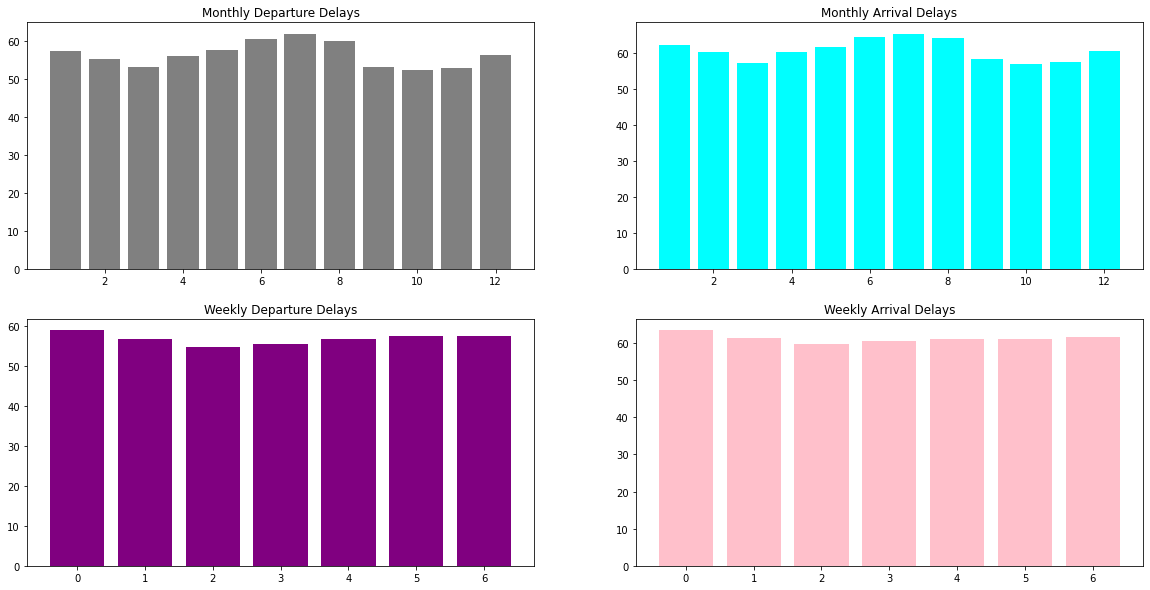

In [14]:
avg_month_delays = US_flight_data.groupby(['Month'])[['DEP_DELAY', 'ARR_DELAY']].mean()
avg_dow_delays = US_flight_data.groupby(['Day of Week'])[['DEP_DELAY', 'ARR_DELAY']].mean()

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].bar(avg_month_delays.index, avg_month_delays['DEP_DELAY'], color = 'grey')
ax[0, 0].set_title('Monthly Departure Delays')
ax[0, 1].bar(avg_month_delays.index, avg_month_delays['ARR_DELAY'], color = 'cyan')
ax[0, 1].set_title('Monthly Arrival Delays')
ax[1, 0].bar(avg_dow_delays.index, avg_dow_delays['DEP_DELAY'], color = 'purple')
ax[1, 0].set_title('Weekly Departure Delays')
ax[1, 1].bar(avg_dow_delays.index, avg_dow_delays['ARR_DELAY'], color = 'pink')
ax[1, 1].set_title('Weekly Arrival Delays')


Pie chart of delay reasons based on selected Carrier

In [15]:
#Group by carriers
delay_reasons = US_flight_data.groupby(['OP_CARRIER'])['CARRIER_DELAY','WEATHER_DELAY', 
                                'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'].sum()

@interact
def show_delay_reasons(x=US_flight_data['OP_CARRIER'].unique()):
    #Filter based on Carrier
    carrier = delay_reasons.loc[[x]]
    #Pie chart
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis('equal')
    ax.pie(carrier, labels = delay_reasons.columns , autopct='%1.1f%%', startangle=15, 
           shadow = True)
    plt.show()

c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


interactive(children=(Dropdown(description='x', options=('AA', 'EV', 'MQ', 'YV', 'DL', '9E', 'YX', 'OO', 'VX',…

# Binary Logistic Regression

Predicting whether or not there is a delay based on Scheduled Departure and Arrival time as well as Carrier.

In [16]:
numerical_attr = ['CRS_DEP_TIME', 'CRS_ARR_TIME']
#Carrier
print('Number of Carriers: ', len(US_flight_data['OP_CARRIER'].unique()))

Number of Carriers:  20


There are 20 different carriers. Converting them all to dummies will create too many variables.

Carriers with freq < 10 will be grouped into 1 group

0% < freq < 10%: low_freq

In [17]:
freq = (US_flight_data['OP_CARRIER'].value_counts() / len(US_flight_data['OP_CARRIER']))*100
print('Frequency of each carrier:\n', freq)
#Grouping
US_flight_data['OP_CARRIER_Group'] = ["low_freq" if freq[US_flight_data['OP_CARRIER'][i]] < 10 
                                      else US_flight_data['OP_CARRIER'][i]
                                      for i in range(len(US_flight_data['OP_CARRIER']))]

Frequency of each carrier:
 WN    22.830631
AA    13.598153
DL    10.862445
OO    10.646748
UA     9.287540
EV     8.262894
B6     5.978014
MQ     3.859220
AS     2.390614
NK     2.278686
F9     2.161838
US     1.931751
VX     1.079370
YX     1.007088
OH     0.993973
9E     0.772736
YV     0.755586
HA     0.687693
G4     0.375766
FL     0.239254
Name: OP_CARRIER, dtype: float64


Create Dummies

In [18]:
#Carrier
carrier_dummies = pd.get_dummies(US_flight_data['OP_CARRIER_Group'], drop_first=True)

#Concatinate them to the dataset
US_flight_data_dummy = pd.concat([US_flight_data, carrier_dummies], axis = 1)

#'AA' is not included to avoid the dummy variable trap
binary_attr = ['DL', 'OO', 'WN', 'low_freq']

Define Dependent and Independant variables and create the model instance

In [19]:
#Independant variables
X_logistic = US_flight_data_dummy[numerical_attr + binary_attr].copy()
#Dependent variable
y = [1 if US_flight_data['DEP_DELAY'][i] > 0 else 0 for i in range(len(US_flight_data))]
#Create model instance
model = LogisticRegression(C=1e5, solver='lbfgs')

Polynomial Features

In [20]:
poly = PolynomialFeatures(degree=2)
#fit_transform for all independant variables
X_poly = []
X_poly = [poly.fit_transform(X_logistic.iloc[:, i].values.reshape(-1,1)) 
          for i in range(0, X_logistic.shape[1])]
#Convert to DataFrame
X_poly_df = [pd.DataFrame(X_poly[i]) for i in range(0, len(X_poly))]
X_poly_df = pd.concat(X_poly_df, axis=1)

Split the dataset: 20% test, 80% train and fit the model

In [21]:
#Split the dataset 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df, y, test_size=0.2)

Scaling the independant features and fitting the model on the scaled training data

In [22]:
#Scaling
#Create scaler instance
scaler_x = StandardScaler()
#Scaling numerical attributes only
X_train.iloc[:,0:6] = scaler_x.fit_transform(X_train.iloc[:,0:6])
X_test.iloc[:,0:6] = scaler_x.transform(X_test.iloc[:,0:6])

#Fit the model on the training data
model.fit(X_train, y_train)

c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\natal\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

LogisticRegression(C=100000.0)

Predict and show performance

In [23]:
#Predict y
y_pred = model.predict(X_test)

metrics.accuracy_score(y_test, y_pred)*100

88.76435716112499